# controlnet-depth

拿到深度图

In [4]:
import torch
import numpy as np
from PIL import Image
from transformers import DPTFeatureExtractor, DPTForDepthEstimation

depth_estimator = DPTForDepthEstimation.from_pretrained(
        "/home/zjt/model/dpt-hybrid-midas").to("cuda")
feature_extractor = DPTFeatureExtractor.from_pretrained(
        "/home/zjt/model/dpt-hybrid-midas")
def get_depth_map(image):
    original_size = image.size
    image = feature_extractor(
        images=image, return_tensors="pt").pixel_values.to("cuda")
    with torch.no_grad(), torch.autocast("cuda"):
        depth_map = depth_estimator(image).predicted_depth
    depth_map = torch.nn.functional.interpolate(
        depth_map.unsqueeze(1),
        size=original_size[::-1],
        mode="bicubic",
        align_corners=False,
    )
    depth_min = torch.amin(depth_map, dim=[1, 2, 3], keepdim=True)
    depth_max = torch.amax(depth_map, dim=[1, 2, 3], keepdim=True)
    depth_map = (depth_map - depth_min) / (depth_max - depth_min)
    image = torch.cat([depth_map] * 3, dim=1)
    image = image.permute(0, 2, 3, 1).cpu().numpy()[0]
    image = Image.fromarray((image * 255.0).clip(0, 255).astype(np.uint8))
    return image


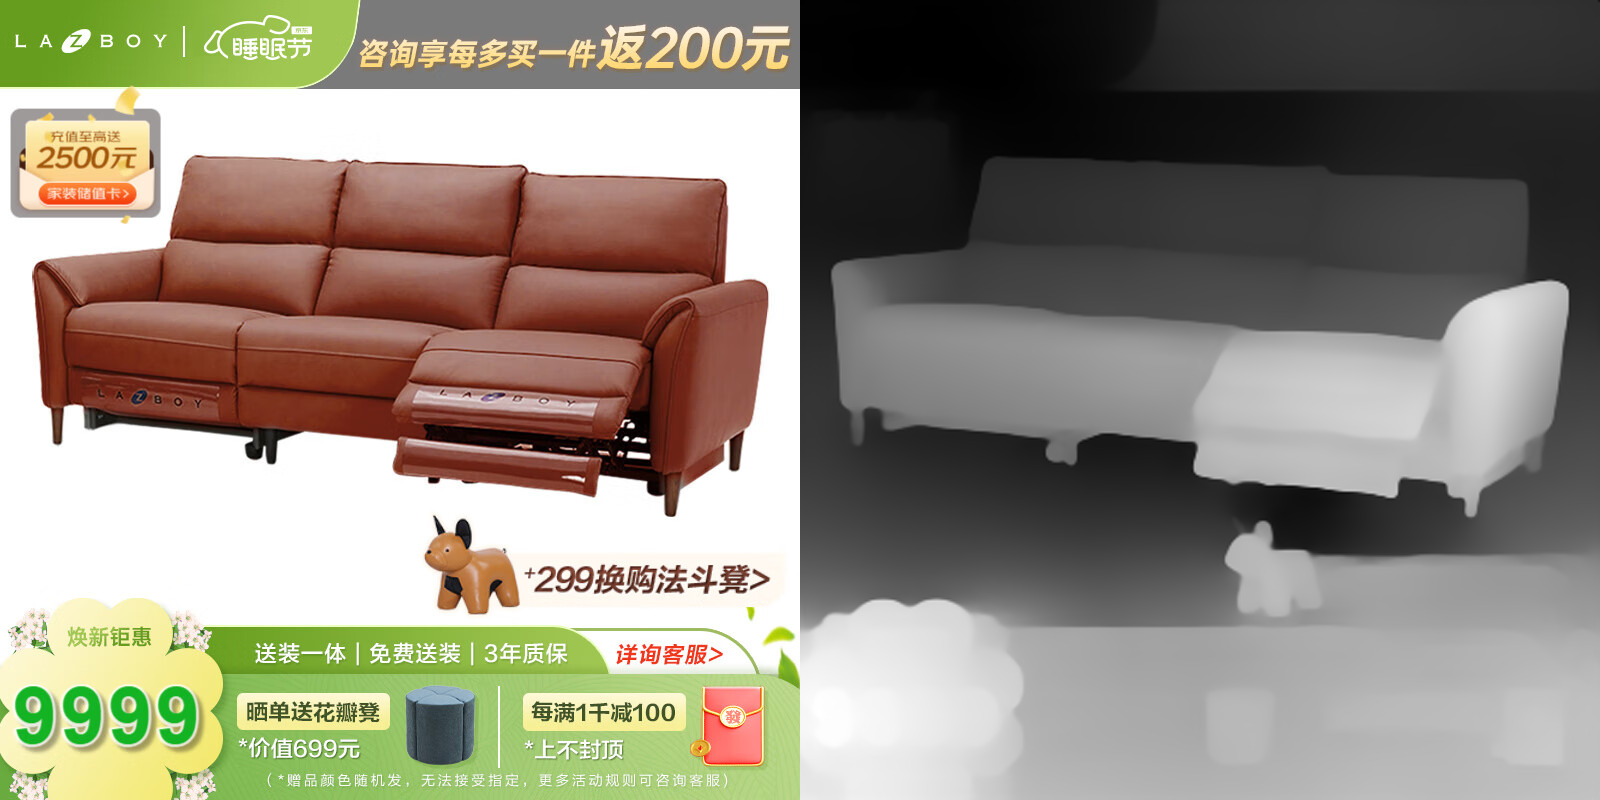

In [20]:
from diffusers.utils import make_image_grid
ori_img = Image.open('/home/zjt/workspace/img2img/images/10036.jpg')
depth_img = get_depth_map(ori_img)
make_image_grid([ori_img,depth_img],rows=1,cols=2)

用我们上次用的分割的模型,拿到分割的mask,和深度图做个点乘.

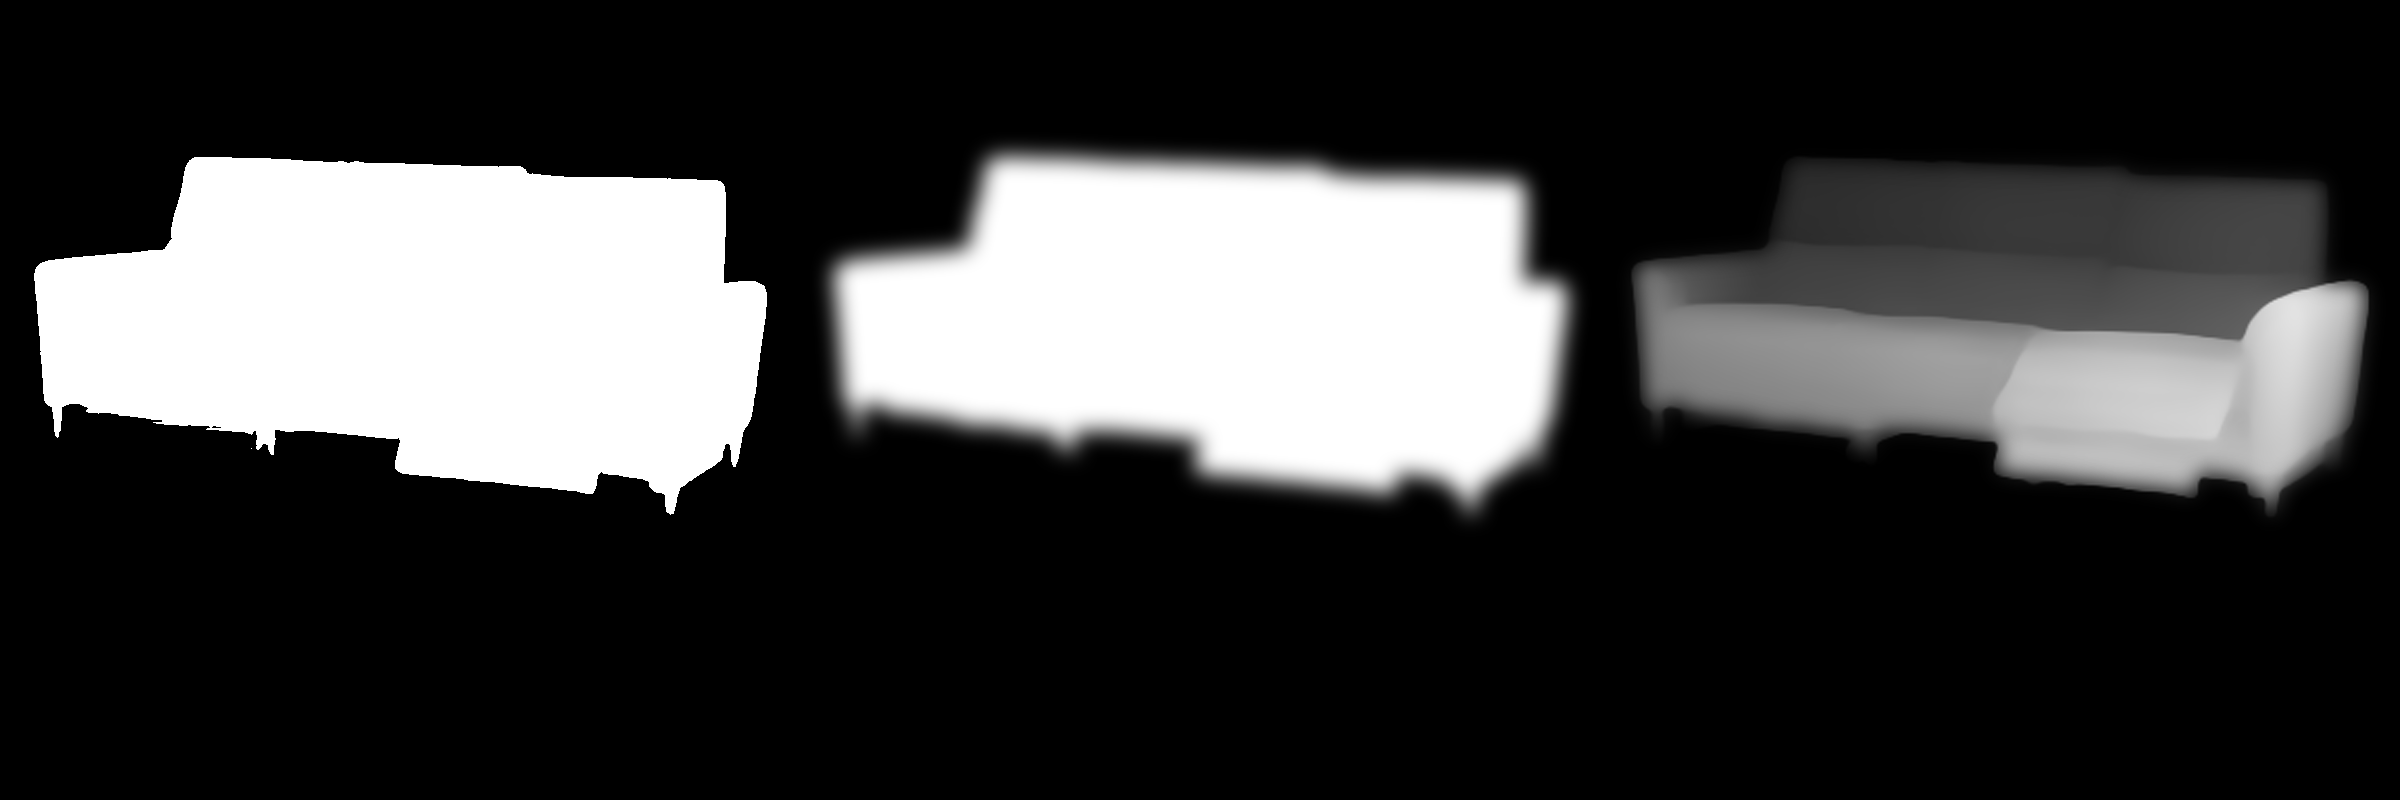

In [31]:
from PIL import ImageFilter

mask_img = Image.open('./images/sofa_mask.png')
GaussianBlur_mask_img = mask_img.filter(
    ImageFilter.GaussianBlur(radius=10))
GaussianBlur_mask_img_np = np.array(GaussianBlur_mask_img.convert('L'))
depth_map_np = np.array(depth_img.convert('L')) / 255.0
masked_depth_map_np = depth_map_np * GaussianBlur_mask_img_np
masked_depth_map_np = (masked_depth_map_np).astype(np.uint8)
masked_depth_map = Image.fromarray(masked_depth_map_np).convert('RGB')
make_image_grid([mask_img,GaussianBlur_mask_img,masked_depth_map],rows=1,cols=3)

用深度图画出一个新的图片

In [8]:
import torch
from diffusers import StableDiffusionXLControlNetPipeline, ControlNetModel, AutoencoderKL, UniPCMultistepScheduler
depth_controlnet = ControlNetModel.from_pretrained(
        "/home/zjt/model/controlnet-depth-sdxl-1.0",
        use_safetensors=True,
        torch_dtype=torch.float16
    ).to("cuda")
vae = AutoencoderKL.from_pretrained(
    "/home/zjt/model/sdxl-vae-fp16-fix",
    torch_dtype=torch.float16,
).to("cuda")
pipe = StableDiffusionXLControlNetPipeline.from_pretrained(
    "/home/zjt/model/stable-diffusion-xl-base-1.0",
    controlnet=[depth_controlnet],
    vae=vae,
    variant="fp16",
    use_safetensors=True,
    torch_dtype=torch.float16
).to("cuda")

pipe.enable_model_cpu_offload()
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_xformers_memory_efficient_attention()


Loading pipeline components...: 100%|██████████| 7/7 [00:08<00:00,  1.25s/it]


100%|██████████| 30/30 [00:29<00:00,  1.01it/s]


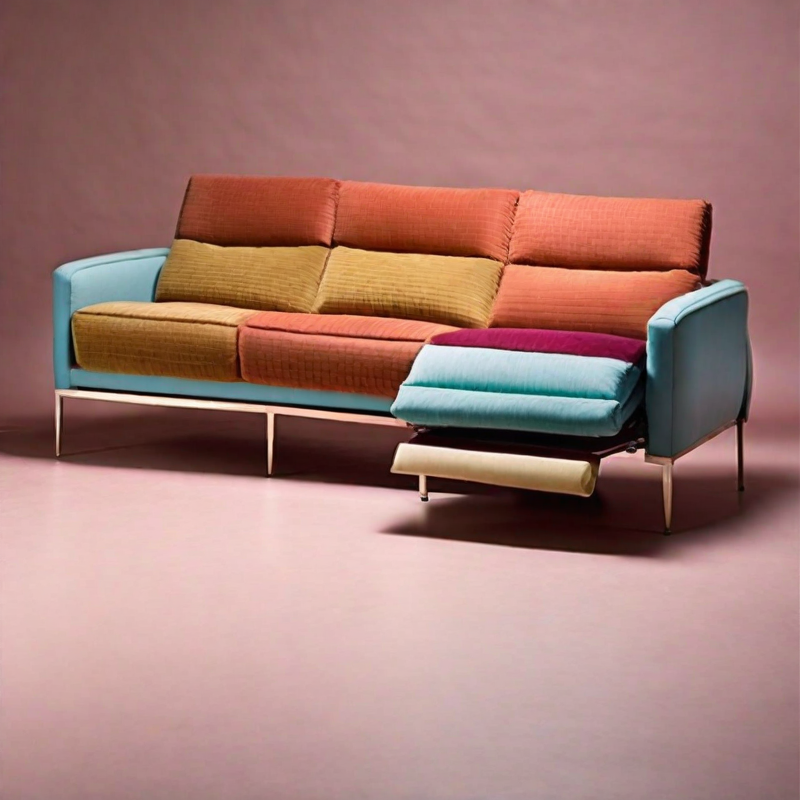

In [35]:
positive_prompt = 'a sofa in a room, commercial product photography, 24mm lens f/8'
negative_prompt = 'disfigured, dismembered, mangled, marred, cartoon, drawing, anime, semi-realistic, illustration, painting, art, text, greyscale, (black and white), lens flare, watermark, cropped, out of frame, worst quality, low quality, jpeg artifacts, ugly, duplicate, morbid, mutilated, extra fingers, mutated hands, poorly drawn hands, poorly drawn face, mutation, deformed, dehydrated, bad anatomy, bad proportions, extra limbs, cloned face, disfigured, gross proportions, malformed limbs, missing arms, missing legs, extra arms, extra legs, fused fingers, too many fingers, long neck, floating, levitating'
images = pipe(
        prompt=positive_prompt,
        negative_prompt=negative_prompt,
        num_inference_steps=30,
        num_images_per_prompt=4,
        controlnet_conditioning_scale=0.65,
        guidance_scale=10.0,
        image=[masked_depth_map]
    ).images
images[0]

如果把原图中的沙发替换到生成的图中,就可以更换背景了.

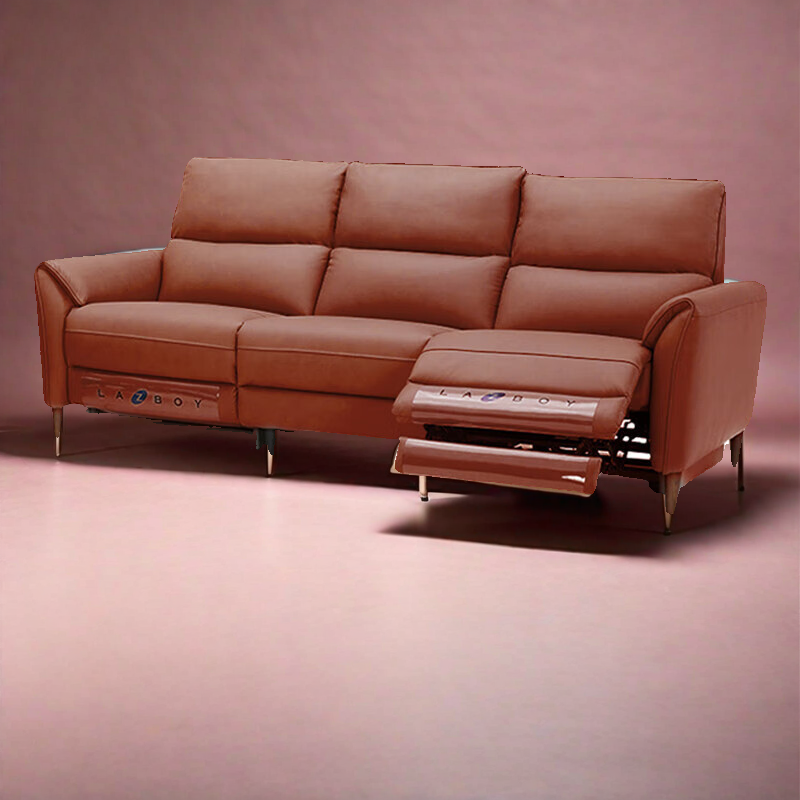

In [44]:
[mask_img,GaussianBlur_mask_img,masked_depth_map]
ori_img = Image.open('/home/zjt/workspace/img2img/images/10036.jpg')

ori_img.putalpha(mask_img)
generated_image = images[0].convert('RGBA')
Image.alpha_composite(
            generated_image,
            ori_img
        )

当然,通过对图片进行一些缩放填充或者移动也是可以的.

In [45]:
def img_resize_pad(image,target_h=1024,target_w=1024,r=0.5):
    shape = image.size
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = target_w - new_unpad[0], target_h - new_unpad[1]
    dw /= 2
    dh /= 2
    image = image.resize(new_unpad)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    
    img = Image.new(image.mode,(target_w,target_h))
    img.paste(image,(left,top))
    return img
new_img = img_resize_pad(ori_img)

100%|██████████| 30/30 [00:48<00:00,  1.60s/it]


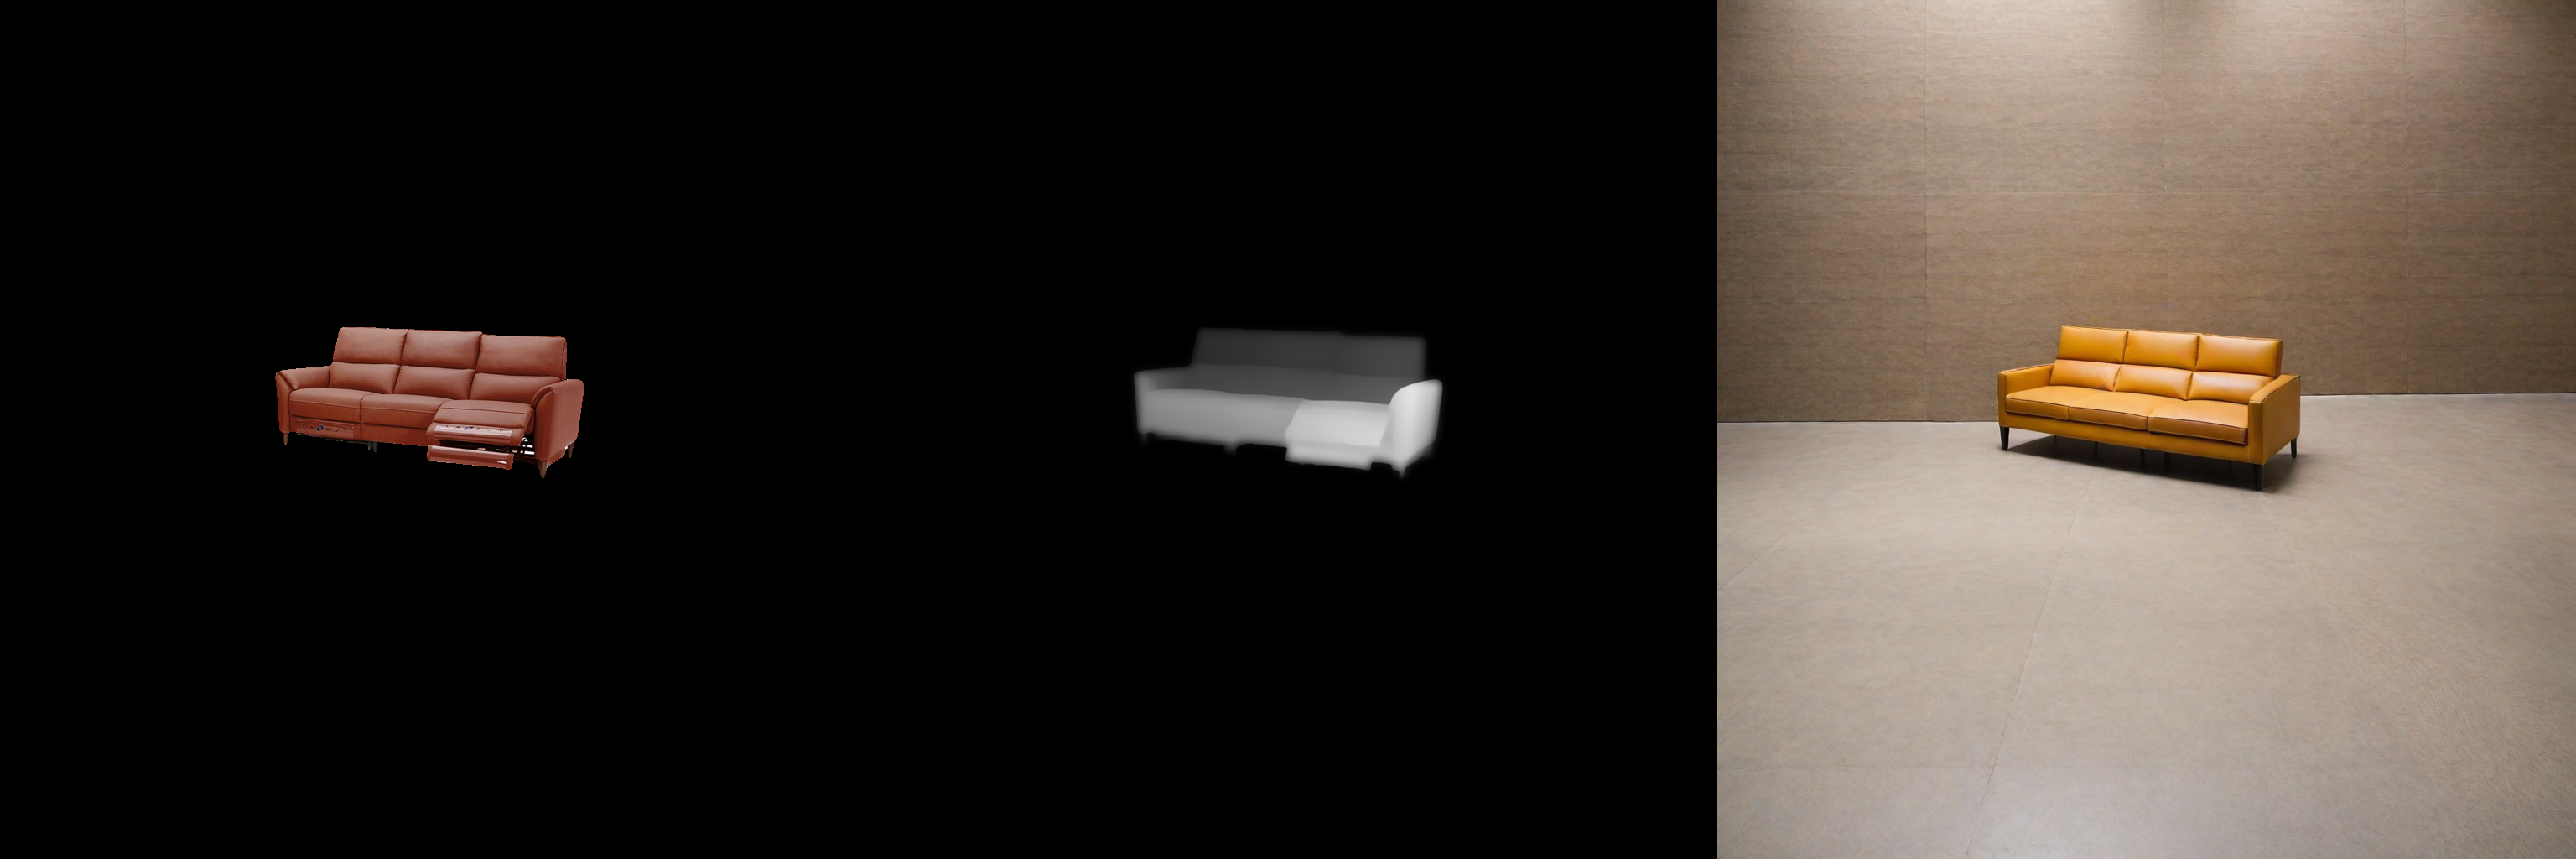

In [46]:
positive_prompt = 'a sofa in a room, commercial product photography, 24mm lens f/8'
negative_prompt = 'disfigured, dismembered, mangled, marred, cartoon, drawing, anime, semi-realistic, illustration, painting, art, text, greyscale, (black and white), lens flare, watermark, cropped, out of frame, worst quality, low quality, jpeg artifacts, ugly, duplicate, morbid, mutilated, extra fingers, mutated hands, poorly drawn hands, poorly drawn face, mutation, deformed, dehydrated, bad anatomy, bad proportions, extra limbs, cloned face, disfigured, gross proportions, malformed limbs, missing arms, missing legs, extra arms, extra legs, fused fingers, too many fingers, long neck, floating, levitating'
new_masked_depth_map = img_resize_pad(masked_depth_map)
new_images = pipe(
        prompt=positive_prompt,
        negative_prompt=negative_prompt,
        num_inference_steps=30,
        num_images_per_prompt=4,
        controlnet_conditioning_scale=0.65,
        guidance_scale=10.0,
        image=[new_masked_depth_map]
    ).images
make_image_grid([new_img,new_masked_depth_map,new_images[0]],rows=1,cols=3)

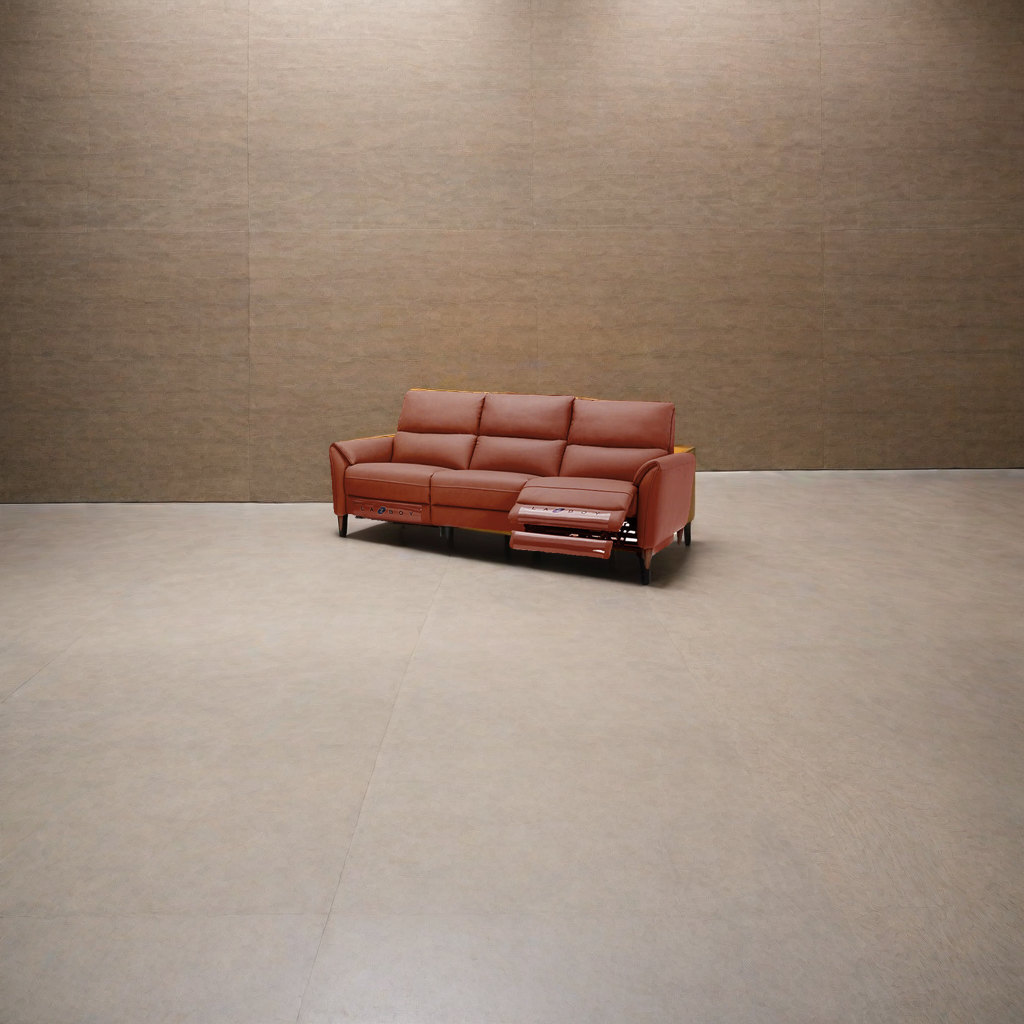

In [47]:
generated_image = new_images[0].convert('RGBA')
Image.alpha_composite(generated_image,new_img)